In [1]:
""" 
We will use subversion to get only 1 folder from our github repo, 
instead of cloning the entire repository using git.clone
(Done by replacing ".../tree/main/S10" with ".../trunk/S10" in the git folder url)
"""
!apt install subversion
!pip install albumentations==0.4.6
!pip install pytorch-gradcam

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1
Suggested packages:
  db5.3-util libapache2-mod-svn subversion-tools
The following NEW packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 subversion
0 upgraded, 5 newly installed, 0 to remove and 10 not upgraded.
Need to get 2,237 kB of archives.
After this operation, 9,910 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libapr1 amd64 1.6.3-2 [90.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libaprutil1 amd64 1.6.1-2 [84.4 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libserf-1-1 amd64 1.3.9-6 [44.4 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libsvn1 amd64 1.9.7-4ubuntu1 [1,183 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic/universe amd64 subversion amd64 1.9.7-4ubuntu1 

In [2]:
!svn update S10
!svn checkout https://github.com/AkhilP9182/EVA5---Extensive-Vision-AI/trunk/S10

A    S10/README.md
A    S10/config.py
A    S10/images
A    S10/images/df
A    S10/lr_finder.py
A    S10/model
A    S10/model/sf
A    S10/resnet.py
A    S10/train_test.py
A    S10/utilities.py
Checked out revision 178.


In [3]:
""" Our folder S10 (which contains all the required files) has been downloaded into the root folder"""
%ls

S10/  sample_data/


In [4]:
import os
folder_name = "S10/"
print("Python files in the folder {}".format(folder_name))
for root, dirs, files in os.walk(folder_name):
    for filename in files:
        if (".py" in filename and ".pyc" not in filename):
            print(filename)

Python files in the folder S10/
resnet.py
config.py
utilities.py
train_test.py
lr_finder.py


We can see that all the required files have been downloaded

## **[1] Importing required packages**

In [5]:
# Importing the necessary packages
import sys
import numpy as np
import torch
import torchvision
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets
import torch.utils.data
import torchvision.transforms as transforms
import matplotlib.pyplot      as plt
from   torchsummary       import summary
import tqdm.notebook as tq
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Importing the custom classes and functions
import S10.config as config
import S10.utilities as util
from S10.resnet import ResNet18
from S10.train_test import train,test
from S10.lr_finder import LRFinder

## **[2] Load Train/Test datasets (with the new mean and std deviation normalization)**

### [2.1] Calculate mean and std. deviation of combined (train+test) data

In [7]:
SEED = 1  # Set Randomization seed for Reproducible results
torch.manual_seed(SEED)                 

if config.USE_CUDA:
    torch.cuda.manual_seed(SEED)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform = util.to_tensor)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = util.to_tensor)
# Train and Test set here are torch tensors
mean_cifar10, std_cifar10 = util.get_mean_std_overall(trainset,testset)

mean_cifar10 = tuple(mean_cifar10.numpy())
std_cifar10 = tuple(std_cifar10.numpy())

print("\nChannelwise Mean of overall CIFAR 10 dataset:\t\t\t{}".format(mean_cifar10))         # mean_cifar10 = (0.49186122, 0.48266134, 0.44720834)
print("Channelwise Standrad Deviation of overall CIFAR 10 dataset:\t{}\n".format(std_cifar10)) # std_cifar10 = (0.24699295, 0.24340236, 0.26160896)

util.dataset_info(trainset,testset)
del trainset,testset

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Channelwise Mean of overall CIFAR 10 dataset:			(0.49186122, 0.48266134, 0.44720834)
Channelwise Standrad Deviation of overall CIFAR 10 dataset:	(0.24699295, 0.24340236, 0.26160896)

Number of classes in CIFAR10   : 10
Number of images for training  : 50000
Number of images for validation: 10000


### [2.2] Getting the PIL image list which would feed into the Albumentation Data fetcher class

In [8]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform = None)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = None)
# Train and Test set here are PIL images
train_images, train_labels, _, _  = util.get_PIL_images(trainset)
print("Train Images loaded")
test_images, test_labels, _,_ = util.get_PIL_images(testset)
print("Test Images loaded")

Files already downloaded and verified
Files already downloaded and verified
Train Images loaded
Test Images loaded


### [2.3] Use Albumentation Dataset creator to create a training and testing set

In [9]:
trainset = util.AlbumentateTrainData(image_list = train_images, labels=train_labels, 
                                     mean = mean_cifar10, std = std_cifar10)
testset  = util.AlbumentateTestData(image_list  = test_images,  labels= test_labels, 
                                    mean = mean_cifar10, std = std_cifar10)
# The mean and std for CIFAR10 are already saved in config.py file, for the train and test loaders respectively

train_loader  = util.train_loader_cifar10(trainset, shuffle = True , num_workers = config.num_workers)
test_loader   = util.test_loader_cifar10(testset,   shuffle = False, num_workers = config.num_workers)

classes = config.CIFAR_classes
print(classes)
num_classes = len(classes)
print("\nNumber of classes = {}".format(num_classes))

('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Number of classes = 10


### [2.4] Plot some images from test set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


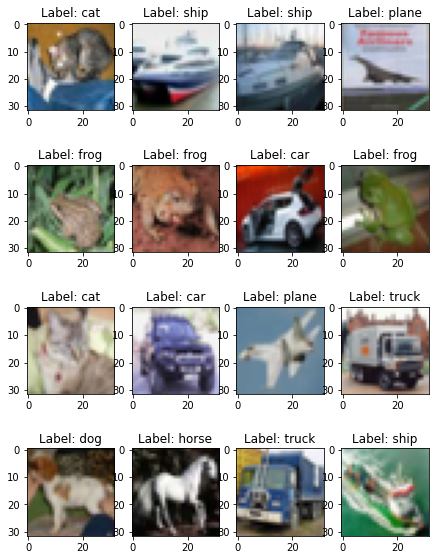

In [10]:
util.plot_images(test_loader, rows=4, cols=4, 
                 mean = mean_cifar10, std=std_cifar10, 
                 classes = list(config.CIFAR_classes))

## **[3] Resnet Model**

In [23]:
device = config.DEVICE                                # Selects whether to run the model on GPU or CPU
model = ResNet18().to(device)                         # Loads the model weights on the gpu or cpu
summary(model, input_size=config.input_size_CIFAR10)  # Shows the sizes of the input and output at each layers for a given input image size, and total parameters

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

## **[4] Training and Testing the model**

### **[4.1] LR Finder**


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.12E-03


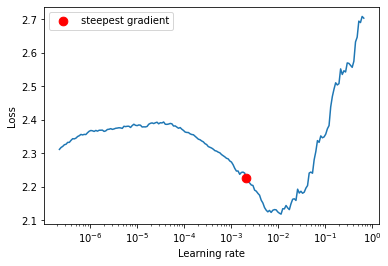

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, weight_decay=0.002)
lr_finder = LRFinder(model, optimizer, criterion, device=config.DEVICE)
lr_finder.range_test(train_loader, end_lr=1, num_iter=200, step_mode="exp")
lr_finder.plot()
lr_finder.reset()

### **[4.2] Train and Test functions**

In [25]:
epochs = config.EPOCHS             # No. of training epochs = 50

train_loss_vals = []
train_acc_vals  = []
test_loss_vals  = []
test_acc_vals   = []

optimizer = optim.SGD(model.parameters(), lr=2.12E-03, momentum=0.9)  # LR taken from the output of LR finder
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                       factor=0.1, patience=5, 
                                                       min_lr=1e-06, eps=1e-08, verbose=False)

max_test_acc = 0
for epoch in range(0, epochs):
    train_loss,train_acc = train(model, config.DEVICE, train_loader, optimizer, epoch, L2_param = 0.002)
    test_loss,test_acc   = test(model, config.DEVICE, test_loader)
    if (test_acc > max_test_acc): # Save the best performing model
        model_path = 'S10/model/S10_best_resnet18_model.model'
        torch.save(model.state_dict(), model_path)
        max_test_acc = test_acc
        print("Model saved at epoch {}".format(epoch))
    scheduler.step(test_loss)       # FOR LR UPDATE
    train_loss_vals.append(train_loss)
    test_loss_vals.append(test_loss)
    train_acc_vals.append(train_acc)
    test_acc_vals.append(test_acc)


Epoch:0 Learning Rate:0.00212
Train Set: Mean loss: 1.3388, Train Accuracy: 26527/50000 (53.05%)
Test Set : Mean loss: 1.2508, Test Accuracy : 5593/10000 (55.93%)

Model saved at epoch 0



Epoch:1 Learning Rate:0.00212
Train Set: Mean loss: 0.9285, Train Accuracy: 33446/50000 (66.89%)
Test Set : Mean loss: 0.8608, Test Accuracy : 7002/10000 (70.02%)

Model saved at epoch 1



Epoch:2 Learning Rate:0.00212
Train Set: Mean loss: 0.7873, Train Accuracy: 36208/50000 (72.42%)
Test Set : Mean loss: 0.7694, Test Accuracy : 7382/10000 (73.82%)

Model saved at epoch 2



Epoch:3 Learning Rate:0.00212
Train Set: Mean loss: 0.6835, Train Accuracy: 38015/50000 (76.03%)
Test Set : Mean loss: 0.6942, Test Accuracy : 7626/10000 (76.26%)

Model saved at epoch 3



Epoch:4 Learning Rate:0.00212
Train Set: Mean loss: 0.7278, Train Accuracy: 37325/50000 (74.65%)
Test Set : Mean loss: 0.7272, Test Accuracy : 7544/10000 (75.44%)




Epoch:5 Learning Rate:0.00212
Train Set: Mean loss: 0.5342, Train Accuracy: 40658/50000 (81.32%)
Test Set : Mean loss: 0.5291, Test Accuracy : 8198/10000 (81.98%)

Model saved at epoch 5



Epoch:6 Learning Rate:0.00212
Train Set: Mean loss: 0.5020, Train Accuracy: 41247/50000 (82.49%)
Test Set : Mean loss: 0.5434, Test Accuracy : 8147/10000 (81.47%)




Epoch:7 Learning Rate:0.00212
Train Set: Mean loss: 0.4522, Train Accuracy: 42029/50000 (84.06%)
Test Set : Mean loss: 0.5038, Test Accuracy : 8267/10000 (82.67%)

Model saved at epoch 7



Epoch:8 Learning Rate:0.00212
Train Set: Mean loss: 0.4049, Train Accuracy: 42903/50000 (85.81%)
Test Set : Mean loss: 0.4675, Test Accuracy : 8357/10000 (83.57%)

Model saved at epoch 8



Epoch:9 Learning Rate:0.00212
Train Set: Mean loss: 0.3723, Train Accuracy: 43544/50000 (87.09%)
Test Set : Mean loss: 0.4728, Test Accuracy : 8410/10000 (84.10%)

Model saved at epoch 9



Epoch:10 Learning Rate:0.00212
Train Set: Mean loss: 0.3990, Train Accuracy: 42990/50000 (85.98%)
Test Set : Mean loss: 0.5218, Test Accuracy : 8276/10000 (82.76%)




Epoch:11 Learning Rate:0.00212
Train Set: Mean loss: 0.3063, Train Accuracy: 44742/50000 (89.48%)
Test Set : Mean loss: 0.4404, Test Accuracy : 8523/10000 (85.23%)

Model saved at epoch 11



Epoch:12 Learning Rate:0.00212
Train Set: Mean loss: 0.3497, Train Accuracy: 43840/50000 (87.68%)
Test Set : Mean loss: 0.4855, Test Accuracy : 8417/10000 (84.17%)




Epoch:13 Learning Rate:0.00212
Train Set: Mean loss: 0.2925, Train Accuracy: 44891/50000 (89.78%)
Test Set : Mean loss: 0.4314, Test Accuracy : 8547/10000 (85.47%)

Model saved at epoch 13



Epoch:14 Learning Rate:0.00212
Train Set: Mean loss: 0.3107, Train Accuracy: 44444/50000 (88.89%)
Test Set : Mean loss: 0.4512, Test Accuracy : 8478/10000 (84.78%)




Epoch:15 Learning Rate:0.00212
Train Set: Mean loss: 0.2885, Train Accuracy: 44965/50000 (89.93%)
Test Set : Mean loss: 0.4665, Test Accuracy : 8494/10000 (84.94%)




Epoch:16 Learning Rate:0.00212
Train Set: Mean loss: 0.3500, Train Accuracy: 43834/50000 (87.67%)
Test Set : Mean loss: 0.5068, Test Accuracy : 8359/10000 (83.59%)




Epoch:17 Learning Rate:0.00212
Train Set: Mean loss: 0.2635, Train Accuracy: 45387/50000 (90.77%)
Test Set : Mean loss: 0.4433, Test Accuracy : 8549/10000 (85.49%)

Model saved at epoch 17



Epoch:18 Learning Rate:0.00212
Train Set: Mean loss: 0.2305, Train Accuracy: 46095/50000 (92.19%)
Test Set : Mean loss: 0.4240, Test Accuracy : 8621/10000 (86.21%)

Model saved at epoch 18



Epoch:19 Learning Rate:0.00212
Train Set: Mean loss: 0.2530, Train Accuracy: 45423/50000 (90.85%)
Test Set : Mean loss: 0.4361, Test Accuracy : 8579/10000 (85.79%)




Epoch:20 Learning Rate:0.00212
Train Set: Mean loss: 0.2387, Train Accuracy: 45829/50000 (91.66%)
Test Set : Mean loss: 0.4402, Test Accuracy : 8613/10000 (86.13%)




Epoch:21 Learning Rate:0.00212
Train Set: Mean loss: 0.1730, Train Accuracy: 47127/50000 (94.25%)
Test Set : Mean loss: 0.3694, Test Accuracy : 8767/10000 (87.67%)

Model saved at epoch 21



Epoch:22 Learning Rate:0.00212
Train Set: Mean loss: 0.1705, Train Accuracy: 47174/50000 (94.35%)
Test Set : Mean loss: 0.3834, Test Accuracy : 8769/10000 (87.69%)

Model saved at epoch 22



Epoch:23 Learning Rate:0.00212
Train Set: Mean loss: 0.1892, Train Accuracy: 46741/50000 (93.48%)
Test Set : Mean loss: 0.3804, Test Accuracy : 8774/10000 (87.74%)

Model saved at epoch 23



Epoch:24 Learning Rate:0.00212
Train Set: Mean loss: 0.2199, Train Accuracy: 46277/50000 (92.55%)
Test Set : Mean loss: 0.4285, Test Accuracy : 8610/10000 (86.10%)




Epoch:25 Learning Rate:0.00212
Train Set: Mean loss: 0.1890, Train Accuracy: 46794/50000 (93.59%)
Test Set : Mean loss: 0.3858, Test Accuracy : 8743/10000 (87.43%)




Epoch:26 Learning Rate:0.00212
Train Set: Mean loss: 0.1745, Train Accuracy: 46984/50000 (93.97%)
Test Set : Mean loss: 0.4039, Test Accuracy : 8739/10000 (87.39%)




Epoch:27 Learning Rate:0.00212
Train Set: Mean loss: 0.1825, Train Accuracy: 46880/50000 (93.76%)
Test Set : Mean loss: 0.4006, Test Accuracy : 8734/10000 (87.34%)




Epoch:28 Learning Rate:0.000212
Train Set: Mean loss: 0.0726, Train Accuracy: 49011/50000 (98.02%)
Test Set : Mean loss: 0.2920, Test Accuracy : 9037/10000 (90.37%)

Model saved at epoch 28



Epoch:29 Learning Rate:0.000212
Train Set: Mean loss: 0.0633, Train Accuracy: 49130/50000 (98.26%)
Test Set : Mean loss: 0.2861, Test Accuracy : 9069/10000 (90.69%)

Model saved at epoch 29



Epoch:30 Learning Rate:0.000212
Train Set: Mean loss: 0.0551, Train Accuracy: 49275/50000 (98.55%)
Test Set : Mean loss: 0.2820, Test Accuracy : 9089/10000 (90.89%)

Model saved at epoch 30



Epoch:31 Learning Rate:0.000212
Train Set: Mean loss: 0.0539, Train Accuracy: 49297/50000 (98.59%)
Test Set : Mean loss: 0.2821, Test Accuracy : 9060/10000 (90.60%)




Epoch:32 Learning Rate:0.000212
Train Set: Mean loss: 0.0496, Train Accuracy: 49377/50000 (98.75%)
Test Set : Mean loss: 0.2768, Test Accuracy : 9098/10000 (90.98%)

Model saved at epoch 32



Epoch:33 Learning Rate:0.000212
Train Set: Mean loss: 0.0455, Train Accuracy: 49450/50000 (98.90%)
Test Set : Mean loss: 0.2813, Test Accuracy : 9083/10000 (90.83%)




Epoch:34 Learning Rate:0.000212
Train Set: Mean loss: 0.0446, Train Accuracy: 49454/50000 (98.91%)
Test Set : Mean loss: 0.2782, Test Accuracy : 9098/10000 (90.98%)




Epoch:35 Learning Rate:0.000212
Train Set: Mean loss: 0.0449, Train Accuracy: 49414/50000 (98.83%)
Test Set : Mean loss: 0.2772, Test Accuracy : 9106/10000 (91.06%)

Model saved at epoch 35



Epoch:36 Learning Rate:0.000212
Train Set: Mean loss: 0.0401, Train Accuracy: 49503/50000 (99.01%)
Test Set : Mean loss: 0.2737, Test Accuracy : 9112/10000 (91.12%)

Model saved at epoch 36



Epoch:37 Learning Rate:0.000212
Train Set: Mean loss: 0.0385, Train Accuracy: 49501/50000 (99.00%)
Test Set : Mean loss: 0.2749, Test Accuracy : 9098/10000 (90.98%)




Epoch:38 Learning Rate:0.000212
Train Set: Mean loss: 0.0386, Train Accuracy: 49520/50000 (99.04%)
Test Set : Mean loss: 0.2765, Test Accuracy : 9129/10000 (91.29%)

Model saved at epoch 38



Epoch:39 Learning Rate:0.000212
Train Set: Mean loss: 0.0371, Train Accuracy: 49516/50000 (99.03%)
Test Set : Mean loss: 0.2818, Test Accuracy : 9096/10000 (90.96%)




Epoch:40 Learning Rate:0.000212
Train Set: Mean loss: 0.0353, Train Accuracy: 49568/50000 (99.14%)
Test Set : Mean loss: 0.2769, Test Accuracy : 9104/10000 (91.04%)




Epoch:41 Learning Rate:0.000212
Train Set: Mean loss: 0.0335, Train Accuracy: 49587/50000 (99.17%)
Test Set : Mean loss: 0.2757, Test Accuracy : 9118/10000 (91.18%)




Epoch:42 Learning Rate:0.000212
Train Set: Mean loss: 0.0319, Train Accuracy: 49627/50000 (99.25%)
Test Set : Mean loss: 0.2755, Test Accuracy : 9132/10000 (91.32%)

Model saved at epoch 42



Epoch:43 Learning Rate:2.12e-05
Train Set: Mean loss: 0.0304, Train Accuracy: 49657/50000 (99.31%)
Test Set : Mean loss: 0.2750, Test Accuracy : 9129/10000 (91.29%)




Epoch:44 Learning Rate:2.12e-05
Train Set: Mean loss: 0.0309, Train Accuracy: 49644/50000 (99.29%)
Test Set : Mean loss: 0.2740, Test Accuracy : 9122/10000 (91.22%)




Epoch:45 Learning Rate:2.12e-05
Train Set: Mean loss: 0.0320, Train Accuracy: 49625/50000 (99.25%)
Test Set : Mean loss: 0.2729, Test Accuracy : 9131/10000 (91.31%)




Epoch:46 Learning Rate:2.12e-05
Train Set: Mean loss: 0.0319, Train Accuracy: 49621/50000 (99.24%)
Test Set : Mean loss: 0.2729, Test Accuracy : 9129/10000 (91.29%)




Epoch:47 Learning Rate:2.12e-05
Train Set: Mean loss: 0.0295, Train Accuracy: 49660/50000 (99.32%)
Test Set : Mean loss: 0.2714, Test Accuracy : 9128/10000 (91.28%)




Epoch:48 Learning Rate:2.12e-05
Train Set: Mean loss: 0.0303, Train Accuracy: 49656/50000 (99.31%)
Test Set : Mean loss: 0.2734, Test Accuracy : 9118/10000 (91.18%)




Epoch:49 Learning Rate:2.12e-05
Train Set: Mean loss: 0.0304, Train Accuracy: 49647/50000 (99.29%)
Test Set : Mean loss: 0.2726, Test Accuracy : 9134/10000 (91.34%)

Model saved at epoch 49


## **[5] Loss and Accuracy Plots**

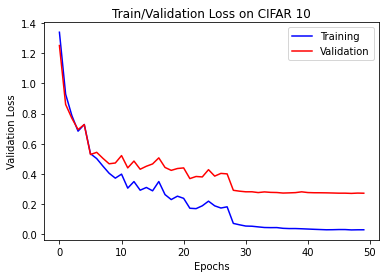

In [40]:
util.plot_loss(train_loss_vals,test_loss_vals,config.EPOCHS)

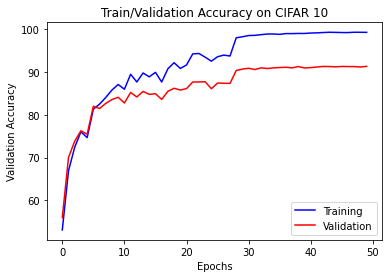

In [39]:
util.plot_acc(train_acc_vals,test_acc_vals,config.EPOCHS)

## **[6] Plot Correctly Classified Images, their predictions and their GradCAM Heatmaps**

Following are the correctly classified images:-


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

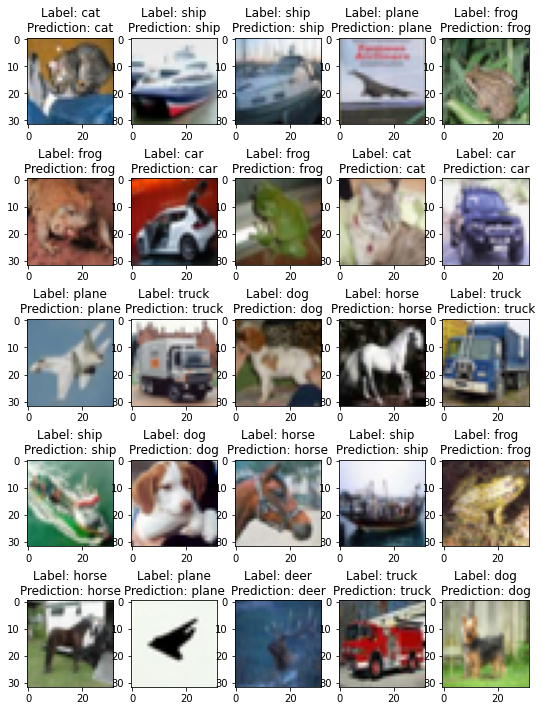

Following are the GradCam Heatmaps for those correctly classified images:-


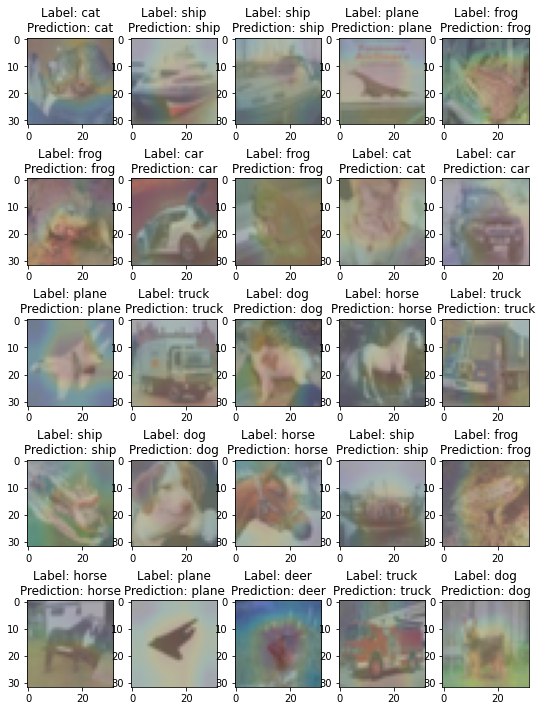

In [38]:
util.plot_correct_classified(ResNet18,"S10/model/S10_best_resnet18_model.model",test_loader,
                   mean=mean_cifar10, std=std_cifar10,
                   classes=config.CIFAR_classes)

## **[7] Plot Misclassified Images, their predictions and their GradCAM Heatmaps**

Following are the mis-classified images:-


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


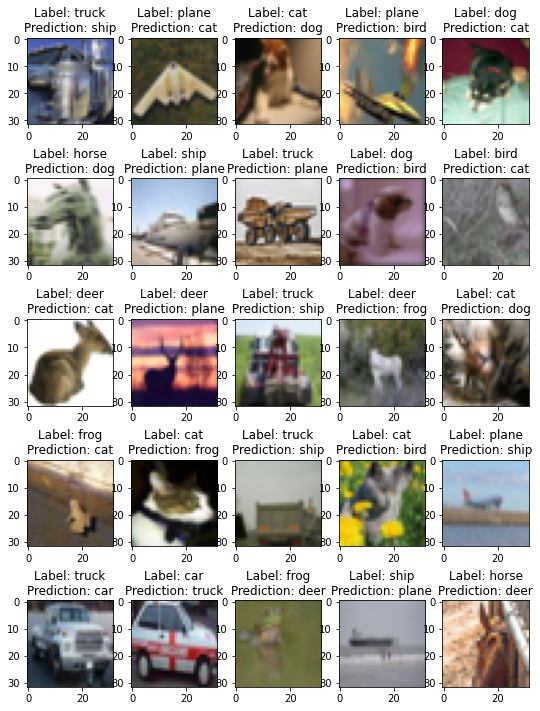

Following are the GradCam Heatmaps for those mis-classified images:-


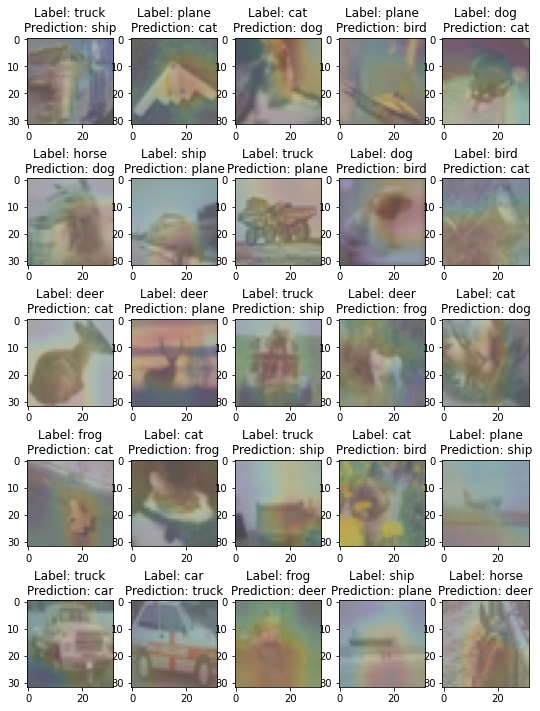

In [37]:
util.plot_misclassified(ResNet18,"S10/model/S10_best_resnet18_model.model",test_loader,
                   mean=mean_cifar10, std=std_cifar10,
                   classes=config.CIFAR_classes)